In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import PipelineTS
PipelineTS.__version__

'0.3.8'

In [3]:
from PipelineTS.dataset import BuiltInSeriesData
bs = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [4]:
import pandas as pd
init_data = bs['Messages_Sent']

time_col = 'date'
target_col = 'ta'
lags = 60
n = 40
accelerator = 'cpu'

init_data = init_data[[time_col, target_col]]
init_data[time_col] = pd.to_datetime(init_data[time_col])
init_data = init_data.sort_values(time_col).reset_index(drop=True)

In [5]:
valid_data = init_data.iloc[-n:, :]
data = init_data.iloc[:-n, :]
print("data shape: ", data.shape, ", valid data shape: ", valid_data.shape)
data.tail(5)

data shape:  (562, 2) , valid data shape:  (40, 2)


,date,ta
557,2021-07-11,125957
558,2021-07-12,139012
559,2021-07-13,127014
560,2021-07-14,118241
561,2021-07-15,114358


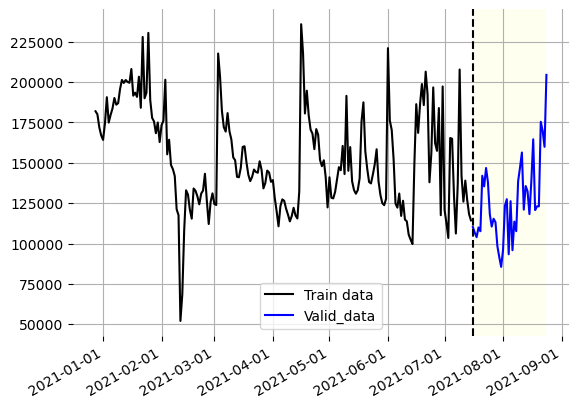

In [6]:
from PipelineTS.plot import plot_data_period
plot_data_period(
    data.iloc[-200:, :], 
    valid_data, 
    time_col=time_col, 
    target_col=target_col, 
    labels=['Train data', 'Valid_data'],
    # date_fmt='%Y-%m-%d %H:%M:%S'  # 支持指定时间格式
)

# PipelineTS

In [7]:
from PipelineTS.pipeline import ModelPipeline, PipelineConfigs

In [8]:
# list all models
ModelPipeline.list_all_available_models()

['auto_arima',
 'catboost',
 'lightgbm',
 'xgboost',
 'wide_gbrt',
 'd_linear',
 'n_linear',
 'n_beats',
 'n_hits',
 'tcn',
 'tft',
 'gau',
 'stacking_rnn',
 'time2vec',
 'multi_output_model',
 'multi_step_model',
 'transformer',
 'random_forest',
 'tide',
 'seg_rnn',
 'prophet']

In [13]:
# 如果希望一次性尝试模型的多个配置，以便进行比较或者调参，请使用PipelineConfigs
# 此功能允许自定义每个ModelPipeline.list_all_available_models()的模型，
# 包括模型初始化参数init_configs、模型拟合参数fit_configs、模型预测参数predict_configs

pipeline_configs = PipelineConfigs([
    ('multi_output_model', {'init_configs': {'verbose': -1}}),
    ('multi_step_model', {'init_configs': {'verbose': -1}}),
])

,model_name,model_name_with_index,model_configs
0,multi_output_model,multi_output_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
1,multi_step_model,multi_step_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"


## quantile prediction

In [10]:
from sklearn.metrics import mean_absolute_error

from PipelineTS.pipeline import ModelPipeline

pipeline = ModelPipeline(
    time_col=time_col,
    target_col=target_col,
    lags=lags,
    random_state=42,
    metric=mean_absolute_error,
    metric_less_is_better=True,
    configs=pipeline_configs,
    include_init_config_model=False,
    use_standard_scale=False,
    with_quantile_prediction=True,  # turn on the quantile prediction switch, if you like
    accelerator=accelerator,
    # models=['wide_gbrt']  # Specify the model
    n_hits__accelerator='cpu',
    tft__accelerator='cpu',
)

In [11]:
pipeline.fit(data, valid_data)

11:35:13 2023-10-31 - PipelineTS - There are a total of 21 models to be trained.
11:35:13 2023-10-31 - PipelineTS - [model  0] fitting and evaluating auto_arima...
11:36:11 2023-10-31 - PipelineTS - [model  1] fitting and evaluating catboost...
11:55:50 2023-10-31 - PipelineTS - [model  2] fitting and evaluating d_linear...
11:56:25 2023-10-31 - PipelineTS - [model  3] fitting and evaluating gau...
11:58:45 2023-10-31 - PipelineTS - [model  4] fitting and evaluating lightgbm...
12:02:55 2023-10-31 - PipelineTS - [model  5] fitting and evaluating multi_output_model_1...
12:07:23 2023-10-31 - PipelineTS - [model  6] fitting and evaluating multi_step_model_1...
12:07:37 2023-10-31 - PipelineTS - [model  7] fitting and evaluating n_beats...
12:08:36 2023-10-31 - PipelineTS - [model  8] fitting and evaluating n_hits...
12:09:51 2023-10-31 - PipelineTS - [model  9] fitting and evaluating n_linear...
12:10:24 2023-10-31 - PipelineTS - [model 10] fitting and evaluating prophet...
12:10:35 2023

Leaderboard,model,train_cost(s),eval_cost(s),metric,quantile_acc
0,n_beats,49.572099,0.014352,19584.698633,0.675
1,prophet,1.685976,0.018932,20629.311013,0.825
2,n_hits,66.185420,0.013497,25226.286719,0.525
3,tide,50.760826,0.014676,25339.908008,0.600
4,auto_arima,48.387772,0.003374,26842.097945,0.350
5,stacking_rnn,75.816208,0.002346,27560.495582,0.325
6,seg_rnn,94.571664,0.002452,27744.784176,0.275
7,catboost,1169.543903,0.032228,30901.968223,0.400
8,lightgbm,240.840374,0.026921,31030.781881,0.450
9,time2vec,328.092566,0.002055,31591.572951,0.375


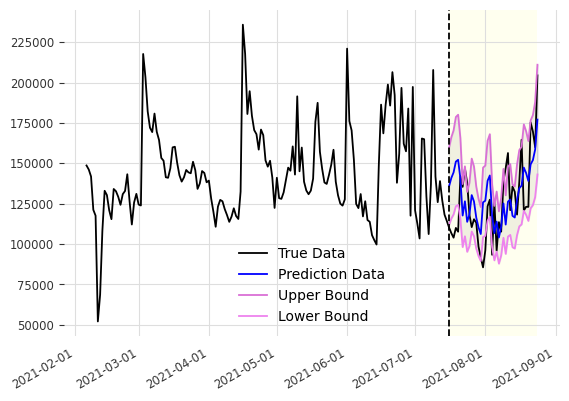

In [12]:
prediction = pipeline.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)